In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Num GPUs Available:  1


In [ ]:
!cp /content/drive/MyDrive/data/dataset.zip /content/
!rm -r dataset
!unzip -q dataset.zip

In [ ]:
def map(x, in_min, in_max, out_min, out_max):
  return (x - in_min) * (out_max - out_min) / (in_max - in_min) + out_min


DATASET_PATH = 'dataset'

data_dir = pathlib.Path(DATASET_PATH)

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print("Numero esempi:", num_samples)
t_len = int(num_samples * 0.7)
v_len = int(num_samples * 0.85)

train_files = filenames[:t_len]
val_files = filenames[t_len:v_len]
test_files = filenames[v_len:]

Numero esempi: 12300


In [ ]:
def get_np(path_name):
  return np.load(path_name.numpy())

def get_label(path_name):
  parts = tf.strings.split(
      input=path_name,
      sep=os.path.sep)
  return parts[-2]
def get_all(path_name):
  label = get_label(path_name).numpy()
  vec = get_np(path_name)
  if label[:2] == b"No":
    label = labels[0]
  else:
    label = labels[1]
  return vec.astype(np.int32), label


labels = np.array(["good", "bad"])
labels

array(['good', 'bad'], dtype='<U4')

In [ ]:
file_np = np.zeros((len(filenames), 5000), dtype=np.int32)
file_lb = []
for i in range(len(filenames)):
  file_np[i, :], lb = get_all(filenames[i])
  file_lb.append(lb)


In [ ]:
print(len(file_lb))
print(file_np.shape)
print(file_np.max(), file_np.min())
print(file_np[0])
for a in range(file_np.shape[0]):
  file_np[a] = map(file_np[a], -3000, 3000, -127, 126)
print(file_np[0])

12300
(12300, 5000)
2651 -1705
[-401 -390 -331 ...  113   67   27]
[-17 -16 -14 ...   4   2   0]


In [ ]:
one = np.ones(5000, dtype=np.int32)
rar = np.random.choice([1,-1], file_np.shape)
file_np1 = file_np + one
file_np2 = file_np - one
file_np3 = file_np + rar
file_res = np.concatenate([file_np, file_np1, file_np2, file_np3])
file_res = np.concatenate([file_res, file_res[:,::-1]])
file_res = np.concatenate([file_res[:,::2], file_res[:,1::2]])
print(file_res.shape)

(196800, 2500)


In [ ]:
np_lab = np.array(file_lb)
np_lab = np.concatenate([np_lab, np_lab, np_lab, np_lab])
np_lab = np.concatenate([np_lab, np_lab])
np_lab = np.concatenate([np_lab, np_lab])
print(file_res.shape)
print(np_lab.shape)
rar = np.random.permutation(np_lab.shape[0])

file_res = file_res[rar].astype(np.int8)
np_lab = np_lab[rar]

(196800, 2500)
(196800,)


In [ ]:
print(file_res.shape)
lent = int(file_res.shape[0] * 0.7)
lenv = int(file_res.shape[0] * 0.85)
print(lent, lenv)

(196800, 2500)
137760 167280


In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((file_res[:lent], np_lab[:lent]))
val_ds = tf.data.Dataset.from_tensor_slices((file_res[lent:lenv], np_lab[lent:lenv]))
test_ds = tf.data.Dataset.from_tensor_slices((file_res[lenv:], np_lab[lenv:]))

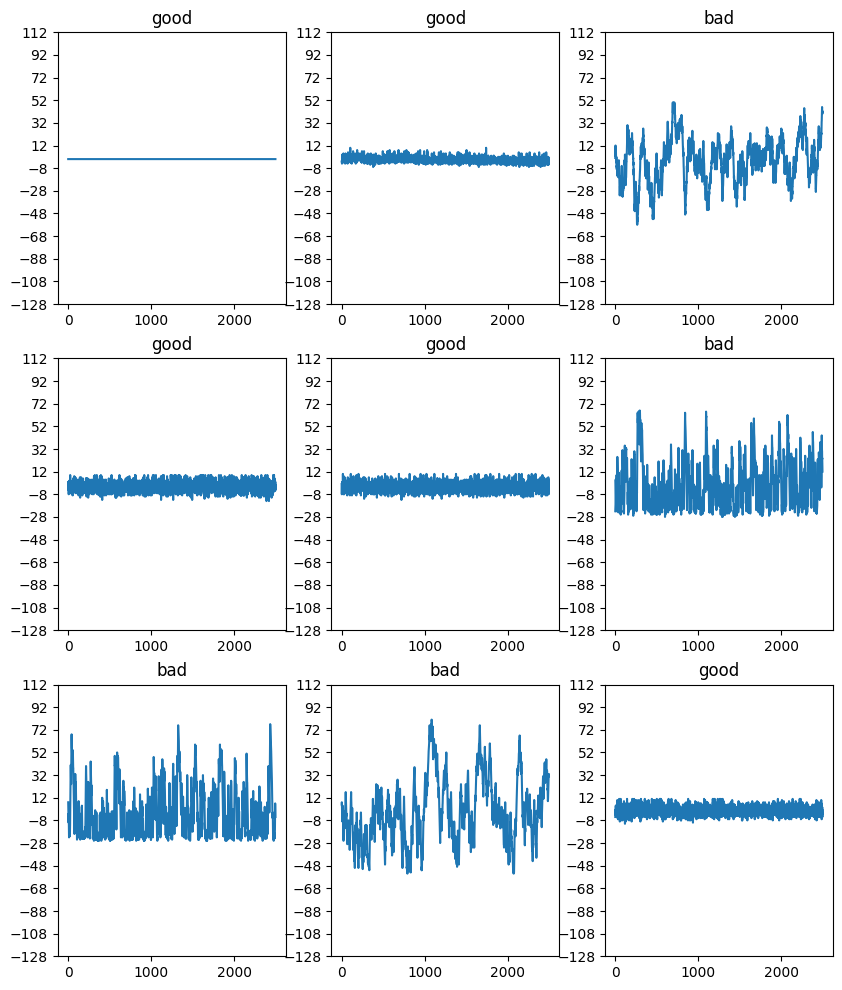

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (vec, lab) in enumerate(train_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(vec.numpy())
  ax.set_yticks(np.arange(-128, 127, 20))
  lab = lab.numpy().decode('utf-8')
  ax.set_title(lab)


In [ ]:
def get_spectro(vec):
  in_len = 5000
  vec = tf.cast(vec, dtype=tf.float32)
  spec = tf.signal.stft(vec, frame_length=255, frame_step=128)
  spec = tf.abs(spec)
  spec = spec[..., tf.newaxis]
  return spec

In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


Label: good
Waveform shape: (5000,)
Spectrogram shape: (38, 129, 1)


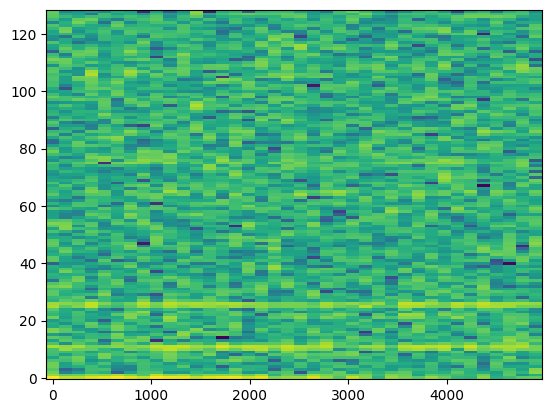

In [ ]:
for waveform, label in train_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectro(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
fig, axes = plt.subplots(1, 1)
plot_spectrogram(spectrogram.numpy(), axes)


In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectro(audio)
  label_id = tf.argmax(label == labels)
  return spectrogram, label_id

spectrogram_ds = train_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)


NameError: in user code:

    File "<ipython-input-19-100f8a33085f>", line 2, in get_spectrogram_and_label_id  *
        spectrogram = get_spectro(audio)

    NameError: name 'get_spectro' is not defined


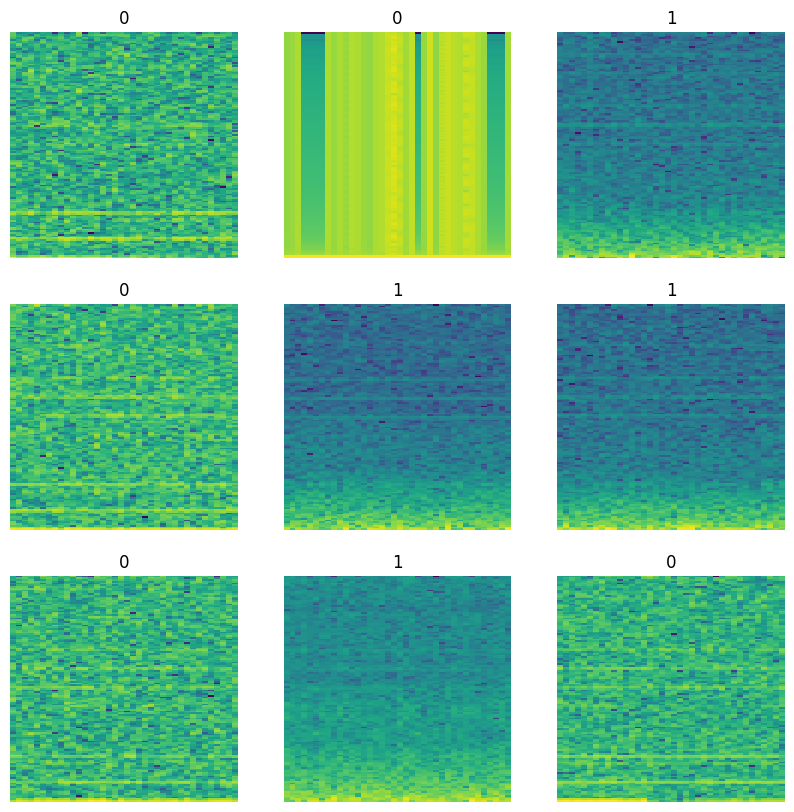

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(label_id.numpy())
  ax.axis('off')

plt.show()


In [ ]:
train_s_ds = train_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)
test_s_ds = test_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)
val_s_ds = val_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 64
train_s_ds = train_s_ds.batch(batch_size)
val_s_ds = val_s_ds.batch(batch_size)


train_s_ds = train_s_ds.cache().prefetch(tf.data.AUTOTUNE)
val_s_ds = val_s_ds.cache().prefetch(tf.data.AUTOTUNE)


In [ ]:
def get_ds_label_id(vec, label):
  label_id = (label == labels)
  return tf.cast(vec, tf.int8), label_id

train_ds = train_ds.map(
  map_func=get_ds_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(
  map_func=get_ds_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(
  map_func=get_ds_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
for spectrogram, _ in train_ds.take(1):
  input_shape = spectrogram.shape[1]
print('Input shape:', input_shape)
num_labels = len(labels)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [layers.Input(shape=input_shape, dtype=tf.int8),
     layers.Dense(128, activation='relu'),
     layers.Dropout(0.35),
     layers.Dense(2, activation='relu'),
]

)

model.summary()

Input shape: 2500
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               320128    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 320386 (1.22 MB)
Trainable params: 320386 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)


In [ ]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=3),
)


Epoch 1/20
2153/2153 [==============================] - 12s 4ms/step - loss: 0.4387 - accuracy: 0.7939 - val_loss: 0.2826 - val_accuracy: 0.8891
Epoch 2/20
2153/2153 [==============================] - 8s 4ms/step - loss: 0.3046 - accuracy: 0.9041 - val_loss: 0.2555 - val_accuracy: 0.9159
Epoch 3/20
2153/2153 [==============================] - 8s 4ms/step - loss: 0.2976 - accuracy: 0.9090 - val_loss: 0.2540 - val_accuracy: 0.9382
Epoch 4/20
2153/2153 [==============================] - 8s 4ms/step - loss: 0.2799 - accuracy: 0.9231 - val_loss: 0.2304 - val_accuracy: 0.9537
Epoch 5/20
2153/2153 [==============================] - 8s 4ms/step - loss: 0.2611 - accuracy: 0.9369 - val_loss: 0.2231 - val_accuracy: 0.9584
Epoch 6/20
2153/2153 [==============================] - 7s 3ms/step - loss: 0.2663 - accuracy: 0.9397 - val_loss: 0.2263 - val_accuracy: 0.9565
Epoch 7/20
2153/2153 [==============================] - 9s 4ms/step - loss: 0.2553 - accuracy: 0.9499 - val_loss: 0.2108 - val_accuracy

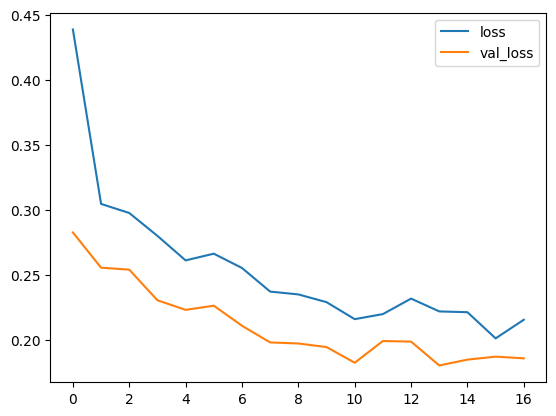

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)


In [ ]:
y_pred = model.predict(test_audio)

print(y_pred)
y_pred= np.argmax(y_pred.squeeze(), axis = 1)
print(y_pred)
y_true = np.argmax(test_labels, axis=1)

test_acc = sum(y_pred == y_true) / len(y_pred)
print(test_acc)

923/923 [==============================] - 2s 2ms/step
[[   0.      1549.3298 ]
 [   0.      1350.2523 ]
 [   0.       420.77014]
 ...
 [   0.      2344.3452 ]
 [   0.       869.19995]
 [   0.         0.     ]]
[1 1 1 ... 1 1 0]
0.9911585365853659


In [ ]:
for a in test_audio[0]:
  print(a)
print(y_true[0])

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(file_res[:36882]).batch(1).take(100):
    # Model has only one input so each data point has one element
    yield [input_value[:,::2]]

print(tf.version.VERSION)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_input_type = tf.int8
tflite_model_quant = converter.convert()

with open('conv.tflite', 'wb') as f:
  f.write(tflite_model_quant)

2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
!xxd -i conv.tflite > conv.h

In [ ]:
for spectrogram, _ in train_s_ds.take(1):
  input_shape = spectrogram.shape[1:]
print('Input shape:', input_shape)
num_labels = len(labels)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_s_ds.map(map_func=lambda spec, label: spec))


model_spec = models.Sequential(
    [layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu', strides=(2,2)),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.45),
    layers.Dense(1, activation='sigmoid'),
]

)

model_spec.summary()

NameError: name 'train_s_ds' is not defined

In [ ]:
model_spec.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 20
history = model_spec.fit(
    train_s_ds,
    validation_data=val_s_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
 66/577 [==>...........................] - ETA: 27s - loss: 0.0061 - accuracy: 0.9988

KeyboardInterrupt: 

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_s_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

NameError: name 'test_s_ds' is not defined

In [ ]:
y_pred = model_spec.predict(test_audio)
y_pred= y_pred.squeeze().round()
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_pred)
print(test_acc)

In [ ]:
for spectrogram, _ in train_ds.take(1):
  input_shape = (spectrogram.shape[1], 1)
print('Input shape:', input_shape)
num_labels = len(labels)

norm_layer = layers.Normalization()
norm_layer.adapt(data=train_ds.map(map_func=lambda spec, label: spec[..., tf.newaxis]))


model_conv = models.Sequential(
    [layers.Input(shape=input_shape, dtype=tf.int8),
     norm_layer,
     layers.Conv1D(16, 16),
     layers.Conv1D(32, 16, activation="relu"),
     layers.MaxPool1D(),
     layers.Conv1D(32, 32, strides=3),
     layers.Conv1D(32, 32, strides=3, activation="relu"),
     layers.MaxPool1D(),
     layers.Dropout(0.30),
     layers.Flatten(),
     layers.Dense(2, activation="relu")
]

)

model_conv.summary()

Input shape: (2500, 1)
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_4 (Normaliza  (None, 2500, 1)           3         
 tion)                                                           
                                                                 
 conv1d_12 (Conv1D)          (None, 2485, 16)          272       
                                                                 
 conv1d_13 (Conv1D)          (None, 2470, 32)          8224      
                                                                 
 max_pooling1d_6 (MaxPoolin  (None, 1235, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 402, 32)           32800     
                                                                 
 conv1d_15 (Conv1D)          (N

In [ ]:

model_conv.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
def newax(vec, label):
  return vec[..., tf.newaxis], label

train_conv = train_ds.map(map_func=newax)
val_conv = val_ds.map(map_func=newax)

with tf.device('/GPU:0'):
  EPOCHS = 20
  history = model_conv.fit(
      train_conv,
      validation_data=val_conv,
      epochs=EPOCHS,
      callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
  )

Epoch 1/20
2153/2153 [==============================] - 32s 14ms/step - loss: 0.0218 - accuracy: 0.9957 - val_loss: 0.0171 - val_accuracy: 0.9987
Epoch 2/20
2153/2153 [==============================] - 31s 14ms/step - loss: 0.0055 - accuracy: 0.9990 - val_loss: 0.0021 - val_accuracy: 0.9997
Epoch 3/20
2153/2153 [==============================] - 35s 16ms/step - loss: 0.0237 - accuracy: 0.9935 - val_loss: 0.0136 - val_accuracy: 0.9964
Epoch 4/20
2153/2153 [==============================] - 30s 14ms/step - loss: 0.0070 - accuracy: 0.9957 - val_loss: 0.0028 - val_accuracy: 0.9992
Epoch 4: early stopping


In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds.map(map_func=newax):
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = model_conv.predict(test_audio)
y_pred= np.argmax(y_pred.squeeze(), axis = 1)
y_true = np.argmax(test_labels, axis=1)

print(y_pred == y_true)

test_acc = np.sum(y_pred == y_true) / len(y_pred)
print(test_acc)

model_conv.save("/content/drive/MyDrive/modelli/model_conv75.keras")

print(file_res.shape)

923/923 [==============================] - 3s 3ms/step
[ True  True  True ...  True  True  True]
0.9991531165311653
(196800, 2500)


In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(file_res[:lent]).batch(1).take(100):
    # Model has only one input so each data point has one element
    yield [input_value[..., tf.newaxis]]

model_conv = tf.keras.models.load_model("/content/drive/MyDrive/modelli/model_conv75.keras")
print(tf.version.VERSION)
converter = tf.lite.TFLiteConverter.from_keras_model(model_conv)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.int8
converter.inference_input_type = tf.int8
tflite_model_quant = converter.convert()

with open('conv.tflite', 'wb') as f:
  f.write(tflite_model_quant)

2.15.0


/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:953: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)
print(output_details)
sum = 0
# Test model on random input data.
for i, a in enumerate(test_audio):
  interpreter.set_tensor(input_details[0]['index'], a[np.newaxis,...])
  interpreter.invoke()
  b = interpreter.get_tensor(output_details[0]['index'])
  sum += np.argmax(test_labels[i]) == b.argmax()
print(sum/len(test_labels))
# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.

[{'name': 'serving_default_input_5:0', 'index': 0, 'shape': array([   1, 2500,    1], dtype=int32), 'shape_signature': array([  -1, 2500,    1], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'StatefulPartitionedCall:0', 'index': 44, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([-1,  2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
0.9991192411924119


In [ ]:
!xxd -i conv.tflite > conv.h

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/modelli/model_spec.keras")

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_7 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_8 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 30, 30, 32)        320       
                                                                 
 conv2d_15 (Conv2D)          (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 7, 7, 64)          0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 7, 7, 64)         

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
conv_tflite = converter.convert()
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

with open('conv.tflite', 'wb') as f:
  f.write(conv_tflite)

In [ ]:
!unzip test.zip

Archive:  test.zip
  inflating: test/file1.npy          
  inflating: test/file2.npy          
  inflating: test/file3.npy          
  inflating: test/file4.npy          
  inflating: test/file5.npy          
  inflating: test/file60.npy         
  inflating: test/file61.npy         
  inflating: test/file62.npy         
  inflating: test/file63.npy         
  inflating: test/file64.npy         


In [ ]:
test = pathlib.Path("test")
testname = tf.io.gfile.glob(str(test) + '/*')
testname.sort()
print(testname)
test_sample = []
for name in testname:
  test_sample.append(np.load(name))
test_sample = np.array(test_sample)
print(test_sample)
model.predict(test_sample)

['test/file1.npy', 'test/file2.npy', 'test/file3.npy', 'test/file4.npy', 'test/file5.npy', 'test/file60.npy', 'test/file61.npy', 'test/file62.npy', 'test/file63.npy', 'test/file64.npy']
[[ 190  206  108 ...  151   82   -2]
 [ 296  207   92 ...  -40 -123 -169]
 [ 700  653  710 ...  390  438  482]
 ...
 [  15   22  -13 ...  -27    8   18]
 [ 137  -51  -41 ...  -26   21  -42]
 [ -24  -23   13 ...   -8  -31   31]]
1/1 [==============================] - 0s 106ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
model.save("/content/drive/MyDrive/modelli/model.keras")
model_spec.save("/content/drive/MyDrive/modelli/model_spec.keras")